[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmed-fouad-lagha/Intro-Data-Security/blob/main/module_01_foundations/Lab1_DNN_Training_and_Robust_Models.ipynb)

# **Lab 1: Deep Neural Network Training & Robust Models**

**Course:** Introduction to Data Security Pr. (Master's Level)  
**Module 1:** Foundations  
**Estimated Time:** 120 minutes

---
In this notebook, we will use the basic training functionalities of SecML-Torch to train a regular PyTorch Deep Neural Network (DNN) classifier.

## **Learning Objectives**

By the end of this lab, you will be able to:

1. **Train** deep neural networks on standard image classification dataset (MNIST)
2. **Evaluate** model performance using standard metrics (accuracy, loss, confusion matrix)
3. **Understand** the difference between standard models and robust models
4. **Load** and compare pre-trained robust models
5. **Analyze** vulnerability of standard models to adversarial perturbations
6. **Establish** baseline models for subsequent security labs

## **Table of Contents**

1. [Setup & Imports](#setup)
2. [Part 1: Dataset Loading & Preprocessing](#part1)
3. [Part 2: Training a Standard DNN](#part2)
4. [Part 3: Evaluating Model Performance](#part3)
5. [Part 4: Adversarial Vulnerability (FGSM)](#part4)
6. [Part 5: Saving & Loading Models](#part5)
7. [Part 6: Loading Pre-trained & Robust Models](#part6)
8. [Conclusion & Next Steps](#conclusion)

## **Setup & Imports** <a name="setup"></a>

First, we'll install necessary libraries and import required modules.

In [1]:
# Install required packages
%pip install torch torchvision matplotlib numpy scikit-learn tqdm secml-torch -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **Part 1: Dataset Loading & Preprocessing** <a name="part1"></a>

We'll work with **MNIST** (handwritten digits) as our primary dataset. MNIST is a standard benchmark for:
- Image classification
- Neural network training
- Adversarial robustness research

**Dataset Details:**
- **Training samples:** 60,000
- **Test samples:** 10,000
- **Image size:** 28×28 grayscale
- **Classes:** 10 (digits 0-9)

In [3]:
# Data preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of batches (train): {len(train_loader)}")

Training samples: 60000
Test samples: 10000
Batch size: 128
Number of batches (train): 469


### **Visualize Sample Images**

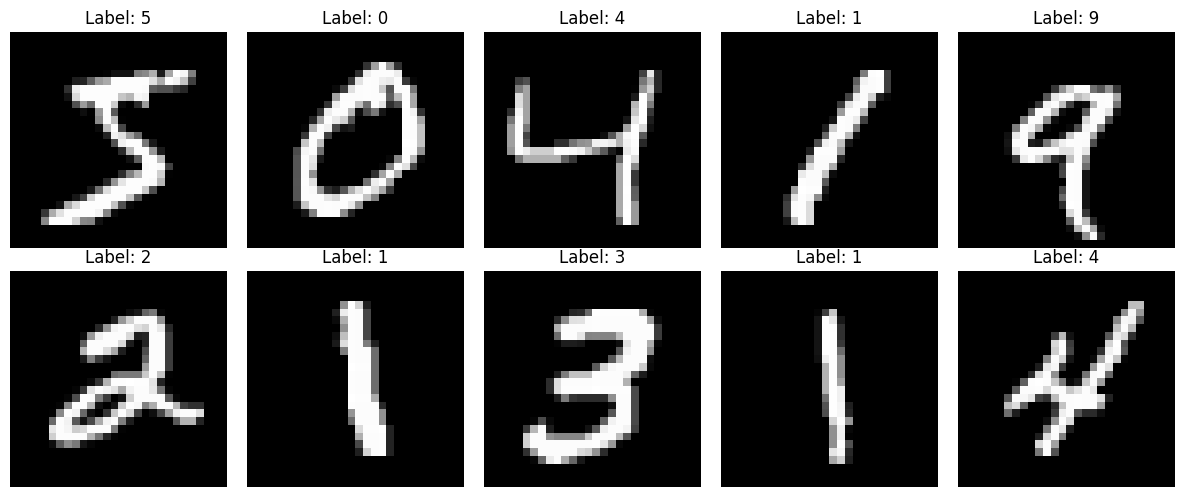

In [4]:
# Visualize some training samples
def show_images(dataset, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for i in range(num_samples):
        image, label = dataset[i]
        # Denormalize for visualization
        image = image * 0.3081 + 0.1307
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_images(train_dataset)

## **Part 2: Training a Standard DNN** <a name="part2"></a>

We'll implement a simple **fully connected network (MLP)** for MNIST classification.

In [5]:
class MNISTNet(torch.nn.Module):
    """Simple fully connected network for MNIST classification."""

    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 200)
        self.fc2 = torch.nn.Linear(200, 200)
        self.fc3 = torch.nn.Linear(200, 10)

    def forward(self, x):
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model
net = MNISTNet().to(device)
print(net)

# Count parameters
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

MNISTNet(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

Total parameters: 199,210
Trainable parameters: 199,210


### **Train the Model**

In [6]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer

# Ensure gradients are enabled (just in case they were disabled by a previous cell)
torch.set_grad_enabled(True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Train with SecML-Torch trainer
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=5)
model = BasePytorchClassifier(model=net, trainer=trainer)

model.train(dataloader=train_loader)
print("Training completed!")

Training completed!


## **Part 3: Evaluating Model Performance** <a name="part3"></a>

In [7]:
from secmlt.metrics.classification import Accuracy

accuracy = Accuracy()(model, test_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.42%


### **Confusion Matrix & Classification Report**

Accuracy can be misleading in security contexts. We also want to see which digits are most frequently confused with others.

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.96      0.98       982
           5       0.96      0.99      0.97       892
           6       0.99      0.96      0.98       958
           7       0.99      0.95      0.97      1028
           8       0.93      0.99      0.96       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



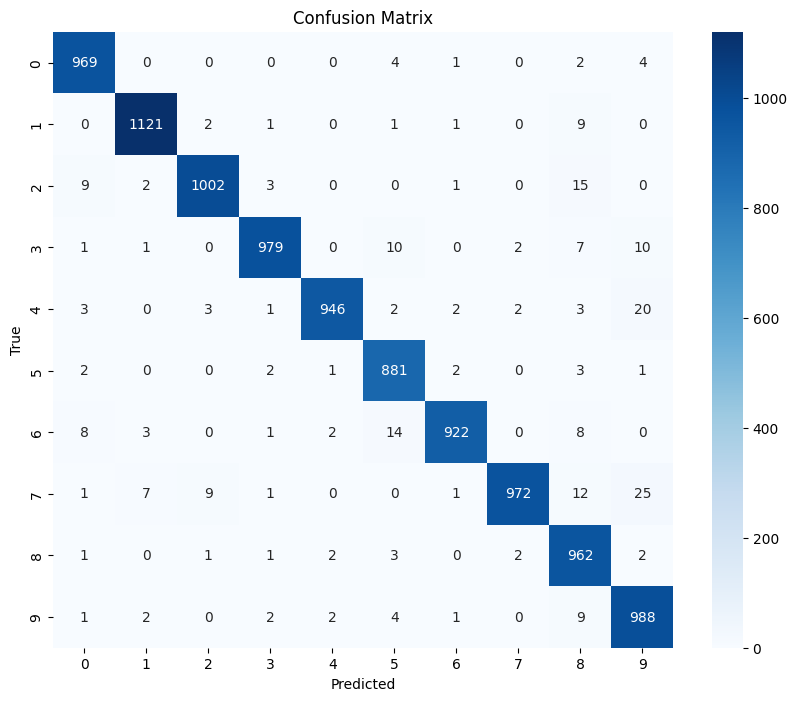

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# We need to collect all predictions and true labels for the full test set
def get_all_preds(model, dataloader):
    all_preds = []
    all_targets = []
    # Access the underlying PyTorch model from BasePytorchClassifier wrapper
    underlying_model = model.model if hasattr(model, 'model') else model
    underlying_model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            out = model.predict(x)
            all_preds.extend(out.cpu().numpy())
            all_targets.extend(y.numpy())
    return np.array(all_preds), np.array(all_targets)

y_pred, y_true = get_all_preds(model, test_loader)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Part 4: Adversarial Vulnerability (FGSM) using SecML-Torch** <a name="part4"></a>

Instead of manually implementing the attack, we can use the `secmlt` library, which provides a unified API for various adversarial attacks. Here we demonstrate the FGSM attack using `secmlt`.

**Key Implementation Detail:** SecML-Torch's PGD with `num_steps=2` performs exactly 1 step at size `step_size`, effectively implementing FGSM. Setting `num_steps=2` (step 1 computes perturbation, step 2 is final) evaluates the best perturbation found.

In [12]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.metrics.classification import Accuracy
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

# MNIST normalization constants
mnist_mean = 0.1307
mnist_std = 0.3081
# Convert image bounds [0, 1] to normalized space
min_val = (0.0 - mnist_mean) / mnist_std
max_val = (1.0 - mnist_mean) / mnist_std

# Test FGSM attack at multiple perturbation magnitudes
epsilons = [0.0, 0.05, 0.1, 0.2]

# Define the FGSM attack using secmlt
results_secmlt = {}

for eps in epsilons:
    if eps == 0:
        acc = Accuracy()(model, test_loader)
    else:
        # Instantiate the attack as a 1-step PGD (FGSM) with native backend
        # num_steps=2: first step computes and applies perturbation, second step evaluates
        attack = PGD(
            perturbation_model=LpPerturbationModels.LINF, 
            epsilon=eps, 
            num_steps=2,  # FGSM is single-step; num_steps=2 evaluates step 1's perturbation
            step_size=eps, 
            random_start=False,
            lb=min_val, 
            ub=max_val, 
            backend=Backends.NATIVE
        )
        
        # Generate adversarial examples and evaluate accuracy
        try:
            adv_loader = attack(model, test_loader)
            acc = Accuracy()(model, adv_loader)
        except Exception as e:
            print(f"Warning: Attack failed for epsilon={eps}: {e}")
            continue
    
    results_secmlt[eps] = acc
    print(f"SecML-Torch FGSM epsilon={eps:.2f} -> accuracy: {acc * 100:.2f}%")

SecML-Torch FGSM epsilon=0.00 -> accuracy: 97.42%
SecML-Torch FGSM epsilon=0.05 -> accuracy: 94.39%
SecML-Torch FGSM epsilon=0.10 -> accuracy: 89.20%
SecML-Torch FGSM epsilon=0.20 -> accuracy: 67.60%


## **Part 5: Saving & Loading Models** <a name="part5"></a>

In [13]:
# Save our trained standard model
model_save_path = 'standard_mnist_dnn.pth'
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'accuracy': accuracy
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to standard_mnist_dnn.pth


In [14]:
# Load the model
def load_model(model_path, model_class, device):
    """Load a saved model."""
    model = model_class().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, checkpoint

# Load our saved model
loaded_model, checkpoint = load_model(model_save_path, MNISTNet, device)
print("Model loaded successfully!")
print(f"Saved model accuracy: {checkpoint['accuracy'] * 100:.2f}%")

Model loaded successfully!
Saved model accuracy: 97.42%


## **Part 6: Loading Pre-trained & Robust Models** <a name="part6"></a>

Up to this point, we have worked with the **MNIST** dataset—a relatively simple, low-dimensional dataset where training a model from scratch takes only a few minutes. However, in modern AI security, we often deal with much more complex data and larger architectures (like ResNets or Vision Transformers).

### **The Shift to ImageNet and Foundation Models**

For large-scale tasks like **ImageNet** classification, training from scratch is computationally expensive and requires specialized hardware. Moreover, developing **robust** models (those resistant to adversarial attacks) is even more intensive, often requiring specialized **adversarial training** loops.

Instead of training our own, we can leverage **industry-standard pre-trained models** and **RobustBench**—a standardized benchmark for adversarial robustness. This section demonstrates how `secml-torch` provides a unified interface to:
1.  **Import** state-of-the-art models from `torchvision` (standard models).
2.  **Load** verified robust models from `RobustBench` (defended models).
3.  **Treat** these complex models exactly like our simple MNIST network.

**Note:** The downloads below can take a few minutes the first time.

In [15]:
%%capture --no-stderr
try:
    import requests
    from PIL import Image
    import robustbench
except ImportError:
    %pip install requests pillow git+https://github.com/RobustBench/robustbench.git

### **6.1 Loading and Preprocessing an Image**

We'll download a sample image and prepare it for inference using the standard ImageNet preprocessing pipeline: resize to 256, center-crop to 224, and convert to tensor.

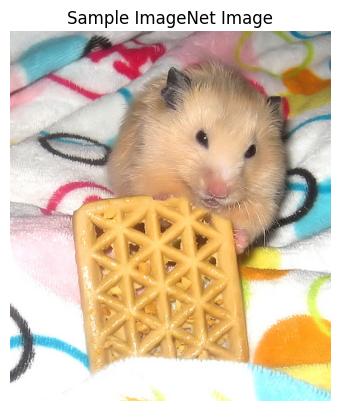

Image loaded successfully


In [19]:
import io
import json
import requests
from PIL import Image
from torchvision import transforms
from torchvision.models import get_model
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from robustbench.utils import load_model

imagenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

img_url = (
    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/"
    "n02342885_10908_hamster.jpg"
 )
labels_url = (
    "https://raw.githubusercontent.com/"
    "anishathalye/imagenet-simple-labels/master/"
    "imagenet-simple-labels.json"
 )

headers = {"User-Agent": "Mozilla/5.0"}

try:
    # Download hamster image with timeout
    resp = requests.get(img_url, headers=headers, timeout=30)
    resp.raise_for_status()
    
    # Download ImageNet labels with timeout
    labels_resp = requests.get(labels_url, headers=headers, timeout=30)
    labels_resp.raise_for_status()
    
    imagenet_labels = json.loads(labels_resp.text)
    img = Image.open(io.BytesIO(resp.content)).convert("RGB")
    
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sample ImageNet Image")
    plt.show()
    
    imagenet_input_tensor = imagenet_transform(img)
    print("Image loaded successfully")
except requests.exceptions.Timeout:
    print("Error: Image download timed out. Skipping ImageNet examples.")
    img = None
    imagenet_labels = None
    imagenet_input_tensor = None
except requests.exceptions.RequestException as e:
    print(f"Error: Failed to download image: {e}. Skipping ImageNet examples.")
    img = None
    imagenet_labels = None
    imagenet_input_tensor = None
except Exception as e:
    print(f"Error: Unexpected error during image loading: {e}. Skipping ImageNet examples.")
    img = None
    imagenet_labels = None
    imagenet_input_tensor = None

### **6.2 Importing a Pre-trained Model from Torchvision**

We load a pre-trained Vision Transformer (ViT) model from torchvision and wrap it using `BasePytorchClassifier`. 

**Note:** First download takes ~3-5 minutes depending on network speed. Subsequent runs are instant.

In [18]:
try:
    imagenet_net = get_model("vit_b_16", weights="IMAGENET1K_V1")
    imagenet_net.to(device)
    imagenet_net.eval()
    
    imagenet_model = BasePytorchClassifier(imagenet_net)
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading ImageNet model: {e}")
    imagenet_model = None

Model loaded successfully


### **6.3 Making Predictions with the Pre-trained Model**

We'll classify the image and map the predicted class index to a human-readable label.

In [20]:
if imagenet_model is not None and imagenet_input_tensor is not None and imagenet_labels is not None:
    imagenet_pred = imagenet_model.predict(imagenet_input_tensor.unsqueeze(0).to(device))
    imagenet_label = imagenet_labels[imagenet_pred.item()]
    print(f"Predicted class index: {imagenet_pred.item()}")
    print(f"Predicted class label: {imagenet_label}")
else:
    print("Cannot make predictions: Model or data failed to load")

Predicted class index: 333
Predicted class label: hamster


### **6.4 Loading a Robust Model from RobustBench**

RobustBench provides models trained for adversarial robustness. We'll load a model robust to $L_\infty$ perturbations and wrap it the same way.

In [22]:
try:
    robust_net = load_model(model_name="Salman2020Do_R18", dataset="imagenet", threat_model="Linf")
    robust_net.to(device)
    robust_net.eval()
    
    robust_model = BasePytorchClassifier(robust_net)
    print("Robust model loaded successfully")
except Exception as e:
    print(f"Error loading robust model: {e}")
    robust_model = None

Robust model loaded successfully


### **6.5 Comparing Predictions**

Robust models may trade clean accuracy for resilience, but on this example both models should agree.

In [23]:
if robust_model is not None and imagenet_input_tensor is not None and imagenet_labels is not None:
    robust_pred = robust_model.predict(imagenet_input_tensor.unsqueeze(0).to(device))
    robust_label = imagenet_labels[robust_pred.item()]
    print(f"Predicted class index: {robust_pred.item()}")
    print(f"Predicted class label: {robust_label}")
else:
    print("Cannot make predictions: Model or data failed to load")

Predicted class index: 333
Predicted class label: hamster


## **Conclusion & Next Steps** <a name="conclusion"></a>
---

### **What You Learned**

- **Neural Network Training:** Built and trained a DNN from scratch  
- **Model Evaluation:** Used accuracy, confusion matrix, and classification reports  
- **Robust Models:** Understood the concept of adversarial robustness  
- **Model Persistence:** Saved and loaded trained models  
- **Baseline Establishment:** Created standard models for future attack labs  

### **Key Takeaways**

1. **Standard models** achieve high clean accuracy but are vulnerable to adversarial attacks
2. **Robust models** trade some clean accuracy for adversarial resilience
3. **Adversarial training** is the most effective defense but computationally expensive
4. **Model architecture** affects both performance and robustness

### **Preparing for Upcoming Labs**

- **Module 2:** Implement and defend against evasion attacks
- **Module 3-4:** Execute and detect poisoning attacks
- **Module 5:** Create and mitigate sponge attacks
- **Module 6:** Launch and prevent privacy attacks
- **Module 7:** Generate and evaluate synthetic data
- **Module 8:** Deploy comprehensive defense systems

### **Additional Resources**

**Foundational Papers:**
- [Explaining and Harnessing Adversarial Examples (Goodfellow et al., 2015)](https://arxiv.org/abs/1412.6572)
- [Towards Deep Learning Models Resistant to Adversarial Attacks (Madry et al., 2018)](https://arxiv.org/abs/1706.06083)
- [Adversarial Examples Are Not Bugs, They Are Features (Ilyas et al., 2019)](https://arxiv.org/abs/1905.02175)
- [SoK: Security and Privacy in Machine Learning (Papernot et al., 2018)](https://ieeexplore.ieee.org/document/8406613)
- [The NIST Adversarial ML Framework](https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.100-2e2023.pdf)

**Industry Standards:**
- MITRE ATLAS: Adversarial Threat Landscape for AI Systems
- OWASP Machine Learning Security Top 10
- ISO/IEC 24029: AI Trustworthiness

**Tools & Frameworks:**
- [SecML-Torch](https://secml-torch.readthedocs.io/)
- [Microsoft Threat Modeling Tool](https://www.microsoft.com/en-us/securityengineering/sdl/threatmodeling)
- [Adversarial Robustness Toolbox (ART)](https://github.com/Trusted-AI/adversarial-robustness-toolbox)